In [5]:
#First we import the necessary modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import random

In [6]:
#Then we mount the google drive to save the results in
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#Next we determine whether the training will be done on the CPU or GPU
if torch.cuda.is_available():
  device = 'cuda'
  print('GPU available')
else:
  device = "cpu"
  print('training is done on CPU')

training is done on CPU


In [10]:
#After that we load our model vgg19 from torchvision to the device
model = models.vgg19(pretrained=True)
model.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 107MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
#Additionally we create transformations for both training data and validation data
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding=10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

In [ ]:
#Then we load our training dataset CIFAR10 from torchvison
ROOT = '.data'

train_data = datasets.CIFAR10(ROOT,
                              train=True,
                              download=True,
                              transform=train_transforms)

test_data = datasets.CIFAR10(ROOT,
                             train=False,
                             download=True,
                             transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Next we split the training data into 2 parts: training data and validation data, and we also split the testing data to a reasonable amountadv
train_data, _ = data.random_split(train_data,
                                           [int(len(train_data) * 0.25), int(len(train_data) * 0.75)])

VALID_RATIO = 0.9

n_train_set = int(len(train_data) * VALID_RATIO)
n_valid_set = len(train_data) - n_train_set

train_data, valid_data = data.random_split(train_data,
                                           [n_train_set, n_valid_set])

test_data, _ = data.random_split(test_data,
                                           [int(len(test_data) * 0.125), int(len(test_data) * 0.875)])

print(f'Number of training samples: {len(train_data)}')
print(f'Number of validation samples: {len(valid_data)}')
print(f'Number of testing samples: {len(test_data)}')

Number of training samples: 11250
Number of validation samples: 1250
Number of testing samples: 1250


In [ ]:
#We load our data with dataloader and set the batch size to 4.
batch_size = 4

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid_data, batch_size=batch_size)
testloader = DataLoader(test_data)
print('Total amount of batches in trainloader: ', len(trainloader), ', validloader: ', len(validloader), ', and testloader', len(testloader))

Total amount of batches in trainloader:  2813 , validloader:  313 , and testloader 1250


In [ ]:
#Function for determining accuracy of output data
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
#setting our optimizier, uploading criterion and model to the device
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
#The function for training the model
def train_model(model, dataloader, optimizer, current_epoch):

  model.train()
  total_loss = 0.0
  total_accuracy = 0.0

  for t, data in enumerate(tqdm(dataloader)):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    pred = model(images)
    loss = nn.CrossEntropyLoss()(pred,  labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_accuracy += multiclass_accuracy(pred, labels)
  return total_loss/len(dataloader), total_accuracy / len(dataloader)


In [ ]:
#Function for validating the model
def eval_model(model, dataloader, current_epoch):

  model.eval()
  total_loss = 0.0
  total_accuracy = 0.0

  for t, data in enumerate(tqdm(dataloader)):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    pred = model(images)
    loss = nn.CrossEntropyLoss()(pred,  labels)

    total_loss += loss.item()
    total_accuracy += multiclass_accuracy(pred, labels)
  return total_loss/len(dataloader), total_accuracy / len(dataloader)


In [ ]:
#Function for testing the model
def test_model(model, dataloader, current_epoch=1):

  model.eval()
  total_loss = 0.0
  total_accuracy = 0.0

  for t, data in enumerate(tqdm(dataloader)):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    pred = model(images)
    loss = nn.CrossEntropyLoss()(pred,  labels)

    total_loss += loss.item()
    total_accuracy += multiclass_accuracy(pred, labels)
  return total_loss/len(dataloader), total_accuracy / len(dataloader)

In [ ]:
#Training our model and saving the best model whoch was the least loss
best_loss=np.Inf
train_losses=[]
valid_losses=[]
for i in range(10):
  train_loss, train_accuracy=train_model(model, trainloader, optimizer, i)
  print(f"Current epoch:{i},  train loss:{train_loss},  train accuracy:{train_accuracy}")
  train_losses.append(train_loss)
  valid_loss, valid_accuracy=eval_model(model, validloader, i)
  print(f"Current epoch:{i},  valid loss:{valid_loss},  valid accuracy:{valid_accuracy}")
  valid_losses.append(valid_loss)
  if valid_loss < best_loss:
    torch.save(model.state_dict(), "/content/drive/MyDrive/image_classifier/best_model.pt")
    best_loss=valid_loss

  0%|          | 0/2813 [00:00<?, ?it/s]

Current epoch:0,  train loss:2.2641551265545345,  train accuracy:0.33754000067710876


  0%|          | 0/313 [00:00<?, ?it/s]

Current epoch:0,  valid loss:1.8800552601631457,  valid accuracy:0.3937699794769287


  0%|          | 0/2813 [00:00<?, ?it/s]

Current epoch:1,  train loss:2.014081679297816,  train accuracy:0.3840206265449524


  0%|          | 0/313 [00:00<?, ?it/s]

Current epoch:1,  valid loss:1.703629096666464,  valid accuracy:0.42811501026153564


  0%|          | 0/2813 [00:00<?, ?it/s]

Current epoch:2,  train loss:1.8282065963961245,  train accuracy:0.42525774240493774


  0%|          | 0/313 [00:00<?, ?it/s]

Current epoch:2,  valid loss:1.5434555812194324,  valid accuracy:0.4816294014453888


  0%|          | 0/2813 [00:00<?, ?it/s]

Current epoch:3,  train loss:1.6876679014161606,  train accuracy:0.45627444982528687


  0%|          | 0/313 [00:00<?, ?it/s]

Current epoch:3,  valid loss:1.404409758960858,  valid accuracy:0.52555912733078


  0%|          | 0/2813 [00:00<?, ?it/s]

Current epoch:4,  train loss:1.5914006146393422,  train accuracy:0.4859580397605896


  0%|          | 0/313 [00:00<?, ?it/s]

Current epoch:4,  valid loss:1.3095158429953238,  valid accuracy:0.5495207905769348


  0%|          | 0/2813 [00:00<?, ?it/s]

Current epoch:5,  train loss:1.4871143280633436,  train accuracy:0.515375018119812


  0%|          | 0/313 [00:00<?, ?it/s]

Current epoch:5,  valid loss:1.243214124498276,  valid accuracy:0.5838658213615417


  0%|          | 0/2813 [00:00<?, ?it/s]

Current epoch:6,  train loss:1.3981210837200935,  train accuracy:0.5388375520706177


  0%|          | 0/313 [00:00<?, ?it/s]

Current epoch:6,  valid loss:1.156417470056409,  valid accuracy:0.6070287823677063


  0%|          | 0/2813 [00:00<?, ?it/s]

Current epoch:7,  train loss:1.3168044694263317,  train accuracy:0.5663881897926331


  0%|          | 0/313 [00:00<?, ?it/s]

Current epoch:7,  valid loss:1.0967982192865957,  valid accuracy:0.6158146858215332


  0%|          | 0/2813 [00:00<?, ?it/s]

Current epoch:8,  train loss:1.2427520819148727,  train accuracy:0.5875399708747864


  0%|          | 0/313 [00:00<?, ?it/s]

Current epoch:8,  valid loss:1.0600568320566472,  valid accuracy:0.634984016418457


  0%|          | 0/2813 [00:00<?, ?it/s]

Current epoch:9,  train loss:1.1953938574166991,  train accuracy:0.6037148833274841


  0%|          | 0/313 [00:00<?, ?it/s]

Current epoch:9,  valid loss:0.9937009662865831,  valid accuracy:0.659744381904602


1.0203807130112326


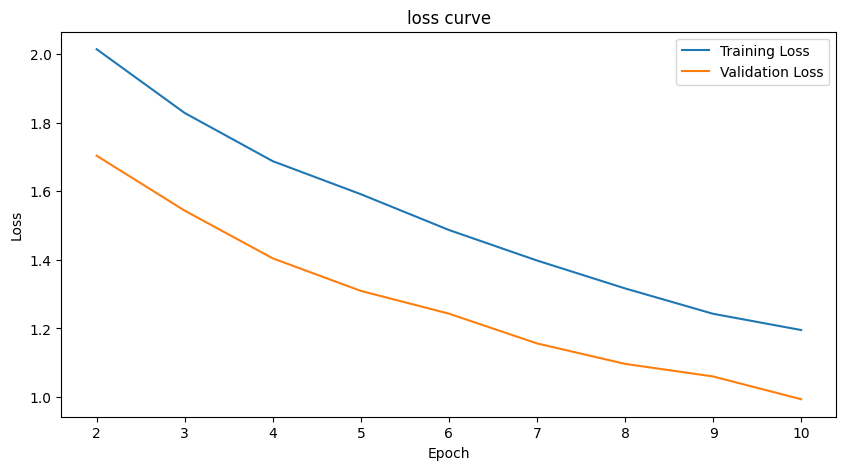

In [ ]:
#Defining a function to draw a plot of loss per epoch both for validation losses and train losses
#Then using the function for our model
def loss_curve(epochs, train_loss, valid_loss):
  epochs = list(range(1, epochs + 1))
  plt.figure(figsize=(10, 5))
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[1:], train_loss[1:], label="Training Loss")
  plt.plot(epochs[1:], valid_loss[1:], label="Validation Loss")
  plt.legend()
  merged_loss = train_losses[1:] + valid_losses[1:]
  highest_loss = max(merged_loss)
  lowest_loss = min(merged_loss)
  delta = highest_loss - lowest_loss
  print(delta)

  up_y_axis = highest_loss + (delta * 0.05)
  bottom_y_axis = lowest_loss - (delta * 0.05)
  plt.title('loss curve')
  plt.ylim([bottom_y_axis, up_y_axis])
  plt.show()

loss_curve(10, train_losses, valid_losses)

In [ ]:
#Determining the model's accuracy and loss on test data
test_loss, test_accuracy=test_model(model, testloader, 0)
print(f"Test loss: {test_loss},  Test accuracy: {test_accuracy}")

  0%|          | 0/1250 [00:00<?, ?it/s]

Test loss: 1.260786200568918,  Test accuracy: 0.6168000102043152
